In [177]:
import pandas as pd
import numpy as np
from google.colab import files
import io
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import json
import os
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [178]:
def columns_without_values(data):
    columns = data.isnull().sum()
    print(columns[columns > 0])

def draw_hist_boxplot(df, feature_name):
    sns.boxplot(x=feature_name, data=df)
    sns.stripplot(x=feature_name, data=df, color="#474646")

def replace_outliers_with_median(df, feature_name):
    Q1 = df[feature_name].quantile(0.25)
    median = df[feature_name].quantile(0.5)
    Q3 = df[feature_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR
    df[feature_name] = np.where((df[feature_name] < lower_whisker) | 
                                (df[feature_name] > upper_whisker), 
                                 median, 
                                 df[feature_name])

In [179]:
path = '/content/drive/MyDrive/coches.net_datos'
df_cols = [
  'url',
  'color',
  'fuelType',
  'km',
  'make',
  'model',
  'price',
  'province',
  'title',
  'transmissionType',
  'year',
  'seller_type',
  'bodyType',
  'cubicCapacity',
  'doors',
  'hp'
]

data = pd.DataFrame(columns=df_cols)
json_files = [json for json in os.listdir(path) if '.json' in json]

for filename in json_files:
  df = pd.read_json(path + '/' + filename)
  try:
    df = df.drop('datetime', axis=1)
  except KeyError:
    pass

try:
  resto_de_datos = pd.json_normalize(df['resto_de_datos']).drop('url', axis=1)
  df = df.drop('resto_de_datos', axis=1)
  df = pd.concat([df, resto_de_datos],  axis=1)
except KeyError:
  pass
    
columnas_eliminar = ['id','brand', 'brand_id', 'fuelTypeId', 'makeId','modelId','provinceId','transmissionTypeId','model_id', 'fuelTypeId', 'fuel_types']
df = df.drop(columnas_eliminar, axis=1)

data = pd.concat([data, df])

data = data.drop_duplicates(subset=['url'])

In [180]:
columnas_eliminar = [
  'id',
  'makeId',
  'modelId',
  'provinceId',
  'transmissionTypeId',
  'fuelTypeId'
]

csv_files = [csv for csv in os.listdir(path) if '.csv' in csv]
for filename in csv_files:
  df = pd.read_csv(path + '/' + filename).drop(columnas_eliminar, axis=1)

try:
  df = df.rename(columns={'body_types':'bodyType'})
except KeyError:
  pass

  
columnas_eliminar_unicas = ['fecha', 'date', 'Unnamed: 0', 'seller_type_id', 'body_types_id', 'publicationDate']
for col in columnas_eliminar_unicas:
  try:
    df = df.drop(col, axis=1)
  except KeyError:
    pass
  
data = pd.concat([data, df])

data['color'] = data['color'].str.replace('COMMON.COLOR_', '')
data['transmissionType'] = data['transmissionType'].str.replace('COMMON.TRANSMISSION_', '')
data['bodyType'] = data['bodyType'].str.replace('BODY_TYPE_', '')

data = data.drop_duplicates(subset=['url'])
data = data.dropna()
data = data.reset_index(drop=True)
data

<ipython-input-180-92c7b240f3b8>:29: FutureWarning: The default value of regex will change from True to False in a future version.
  data['color'] = data['color'].str.replace('COMMON.COLOR_', '')
<ipython-input-180-92c7b240f3b8>:30: FutureWarning: The default value of regex will change from True to False in a future version.
  data['transmissionType'] = data['transmissionType'].str.replace('COMMON.TRANSMISSION_', '')


,url,color,fuelType,km,make,model,price,province,title,transmissionType,year,seller_type,bodyType,cubicCapacity,doors,hp
0,https://www.coches.net/volkswagen-golf-sport-1...,WHITE,Diésel,180000,VOLKSWAGEN,Golf,13990,Guipúzcoa,VOLKSWAGEN Golf Sport 1.6 TDI 110CV BMT DSG 5p.,AUTOMATIC,2016,particular,SEDAN,1598.0,5,110.0
1,https://www.coches.net/volkswagen-multivan-pre...,WHITE,Diésel,34000,VOLKSWAGEN,Multivan,68000,A Coruña,VOLKSWAGEN Multivan Premium Corto 2.0 TDI 110k...,MANUAL,2020,particular,MINIVAN,1968.0,5,150.0
2,https://www.coches.net/volkswagen-caravelle-or...,RED,Diésel,70000,VOLKSWAGEN,Caravelle,36900,Asturias,VOLKSWAGEN Caravelle Origin Corta 2.0 TDI 110k...,AUTOMATIC,2021,profesional,MINIVAN,1968.0,4,150.0
3,https://www.coches.net/volkswagen-tiguan-sport...,GRAY,Diésel,66855,VOLKSWAGEN,Tiguan,33500,Madrid,VOLKSWAGEN Tiguan Sport 2.0 TDI 110kW 150CV DS...,AUTOMATIC,2019,profesional,4X4,1968.0,5,150.0
4,https://www.coches.net/volkswagen-polo-gti-18-...,WHITE,Gasolina,89000,VOLKSWAGEN,Polo,16500,Barcelona,VOLKSWAGEN Polo GTI 1.8 TSI 192cv 3p.,MANUAL,2015,profesional,SEDAN,1798.0,3,192.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710,https://www.coches.net/mazda-cx5-22-d-110kw-15...,WHITE,Diésel,139383.0,MAZDA,CX5,20900.0,A Coruña,MAZDA CX5 2.2 D 110kW 150CV 2WD AT Evolution 5p.,MANUAL,2019.0,profesional,4x4 suv,2191.0,5.0,150.0
2711,https://www.coches.net/mazda-cx5-22-d-110kw-15...,RED,Diésel,69000.0,MAZDA,CX5,24999.0,Madrid,MAZDA CX5 2.2 D 110kW 150CV 2WD AT Zenith,AUTOMATIC,2019.0,profesional,4x4 suv,2191.0,5.0,150.0
2712,https://www.coches.net/mazda-mx5-20-118kw-160c...,WHITE,Gasolina,63912.0,MAZDA,MX5,19400.0,Madrid,MAZDA MX5 2.0 118kW 160CV Style 2p.,MANUAL,2016.0,profesional,cabrio,1998.0,2.0,160.0
2713,https://www.coches.net/mazda-cx5-22-110kw-150c...,GRAY,Diésel,79000.0,MAZDA,CX5,17400.0,Castellón,MAZDA CX5 2.2 110kW 150CV DE 2WD AT Style 5p.,AUTOMATIC,2015.0,profesional,4x4 suv,2191.0,5.0,150.0


In [181]:
data['year'] = data['year'].astype(int)
data['hp'] = data['hp'].astype(int)
data['km'] = data['km'].astype(int)
data['price'] = data['price'].astype(int)
data['doors'] = data['doors'].astype(int)

In [182]:
data = data.drop(['url', 'title'], axis=1)

Obtener información acerca de los datos que se acaban de leer.

In [183]:
data.head()

,color,fuelType,km,make,model,price,province,transmissionType,year,seller_type,bodyType,cubicCapacity,doors,hp
0,WHITE,Diésel,180000,VOLKSWAGEN,Golf,13990,Guipúzcoa,AUTOMATIC,2016,particular,SEDAN,1598.0,5,110
1,WHITE,Diésel,34000,VOLKSWAGEN,Multivan,68000,A Coruña,MANUAL,2020,particular,MINIVAN,1968.0,5,150
2,RED,Diésel,70000,VOLKSWAGEN,Caravelle,36900,Asturias,AUTOMATIC,2021,profesional,MINIVAN,1968.0,4,150
3,GRAY,Diésel,66855,VOLKSWAGEN,Tiguan,33500,Madrid,AUTOMATIC,2019,profesional,4X4,1968.0,5,150
4,WHITE,Gasolina,89000,VOLKSWAGEN,Polo,16500,Barcelona,MANUAL,2015,profesional,SEDAN,1798.0,3,192


In [184]:
data.dtypes

color                object
fuelType             object
km                    int64
make                 object
model                object
price                 int64
province             object
transmissionType     object
year                  int64
seller_type          object
bodyType             object
cubicCapacity       float64
doors                 int64
hp                    int64
dtype: object

In [185]:
pd.isnull(data).any()

color               False
fuelType            False
km                  False
make                False
model               False
price               False
province            False
transmissionType    False
year                False
seller_type         False
bodyType            False
cubicCapacity       False
doors               False
hp                  False
dtype: bool

In [186]:
columns_without_values(data)

Series([], dtype: int64)


In [187]:
data.reset_index(drop=True, inplace=True)

In [188]:
data

,color,fuelType,km,make,model,price,province,transmissionType,year,seller_type,bodyType,cubicCapacity,doors,hp
0,WHITE,Diésel,180000,VOLKSWAGEN,Golf,13990,Guipúzcoa,AUTOMATIC,2016,particular,SEDAN,1598.0,5,110
1,WHITE,Diésel,34000,VOLKSWAGEN,Multivan,68000,A Coruña,MANUAL,2020,particular,MINIVAN,1968.0,5,150
2,RED,Diésel,70000,VOLKSWAGEN,Caravelle,36900,Asturias,AUTOMATIC,2021,profesional,MINIVAN,1968.0,4,150
3,GRAY,Diésel,66855,VOLKSWAGEN,Tiguan,33500,Madrid,AUTOMATIC,2019,profesional,4X4,1968.0,5,150
4,WHITE,Gasolina,89000,VOLKSWAGEN,Polo,16500,Barcelona,MANUAL,2015,profesional,SEDAN,1798.0,3,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710,WHITE,Diésel,139383,MAZDA,CX5,20900,A Coruña,MANUAL,2019,profesional,4x4 suv,2191.0,5,150
2711,RED,Diésel,69000,MAZDA,CX5,24999,Madrid,AUTOMATIC,2019,profesional,4x4 suv,2191.0,5,150
2712,WHITE,Gasolina,63912,MAZDA,MX5,19400,Madrid,MANUAL,2016,profesional,cabrio,1998.0,2,160
2713,GRAY,Diésel,79000,MAZDA,CX5,17400,Castellón,AUTOMATIC,2015,profesional,4x4 suv,2191.0,5,150


In [189]:
campos_numericos = ['km', 'price', 'year', 'cubicCapacity', 'doors', 'hp']

campos_categoricos = ['color', 'fuelType', 'make', 'model', 'province', 'transmissionType', 'seller_type', 'bodyType']

all_feature_names = campos_numericos + campos_categoricos

target = 'price'

In [190]:
for field in campos_categoricos:
  print(field, data[field].unique())
  print('_____________________________________________________________________')

color ['WHITE' 'RED' 'GRAY' 'BLUE' 'ORANGE' 'YELLOW' 'BLACK' 'BROWN' 'BEIGE'
 'GARNET' 'GREEN' 'PURPLE']
_____________________________________________________________________
fuelType ['Diésel' 'Gasolina' 'Híbrido' 'Híbrido enchufable']
_____________________________________________________________________
make ['VOLKSWAGEN' 'BMW' 'MAZDA']
_____________________________________________________________________
model ['Golf' 'Multivan' 'Caravelle' 'Tiguan' 'Polo' 'Passat' 'Touran' 'Arteon'
 'TRoc' 'TCross' 'Touareg' 'Sharan' 'up' 'Golf Sportsvan' 'Scirocco'
 'Tiguan Allspace' 'Beetle' 'CC' 'California' 'Passat CC' 'Jetta' 'Taigo'
 'Caddy' 'Transporter' 'X3' 'Serie 5' 'X5' 'Serie 1' 'Serie 2 Gran Tourer'
 'X4' 'Serie 4' 'X1' 'Serie 3' 'Serie 7' 'X2' 'Serie 6' 'i8' 'Serie 2'
 'Serie 2 Active Tourer' 'i3' 'Serie 8' 'X6' 'X7' 'Z4' 'MX5' 'CX5' 'CX-5'
 'Mazda3' 'CX30' 'Mazda6' 'CX3' 'Mazda2' 'CX7' 'Mazda5' 'CX-3' 'CX-30'
 'MX-5' 'CX9']
____________________________________________________________

In [191]:
for field in campos_categoricos:
  data[field] = data[field].str.upper()

data

,color,fuelType,km,make,model,price,province,transmissionType,year,seller_type,bodyType,cubicCapacity,doors,hp
0,WHITE,DIÉSEL,180000,VOLKSWAGEN,GOLF,13990,GUIPÚZCOA,AUTOMATIC,2016,PARTICULAR,SEDAN,1598.0,5,110
1,WHITE,DIÉSEL,34000,VOLKSWAGEN,MULTIVAN,68000,A CORUÑA,MANUAL,2020,PARTICULAR,MINIVAN,1968.0,5,150
2,RED,DIÉSEL,70000,VOLKSWAGEN,CARAVELLE,36900,ASTURIAS,AUTOMATIC,2021,PROFESIONAL,MINIVAN,1968.0,4,150
3,GRAY,DIÉSEL,66855,VOLKSWAGEN,TIGUAN,33500,MADRID,AUTOMATIC,2019,PROFESIONAL,4X4,1968.0,5,150
4,WHITE,GASOLINA,89000,VOLKSWAGEN,POLO,16500,BARCELONA,MANUAL,2015,PROFESIONAL,SEDAN,1798.0,3,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710,WHITE,DIÉSEL,139383,MAZDA,CX5,20900,A CORUÑA,MANUAL,2019,PROFESIONAL,4X4 SUV,2191.0,5,150
2711,RED,DIÉSEL,69000,MAZDA,CX5,24999,MADRID,AUTOMATIC,2019,PROFESIONAL,4X4 SUV,2191.0,5,150
2712,WHITE,GASOLINA,63912,MAZDA,MX5,19400,MADRID,MANUAL,2016,PROFESIONAL,CABRIO,1998.0,2,160
2713,GRAY,DIÉSEL,79000,MAZDA,CX5,17400,CASTELLÓN,AUTOMATIC,2015,PROFESIONAL,4X4 SUV,2191.0,5,150


In [192]:
print(data['km'].skew())

0.41106401980371093


In [193]:
#scaler = MinMaxScaler()
#data[campos_numericos] = scaler.fit_transform(data[campos_numericos])

#with open('scaler.pkl', 'wb') as f:
   #pickle.dump(scaler, f)

In [194]:
data.to_json('/content/drive/MyDrive/coches.net_datos/datos_finales/final_data.json')

In [195]:
data = pd.read_json('/content/drive/MyDrive/coches.net_datos/datos_finales/final_data.json')

In [196]:
data

,color,fuelType,km,make,model,price,province,transmissionType,year,seller_type,bodyType,cubicCapacity,doors,hp
0,WHITE,DIÉSEL,180000,VOLKSWAGEN,GOLF,13990,GUIPÚZCOA,AUTOMATIC,2016,PARTICULAR,SEDAN,1598,5,110
1,WHITE,DIÉSEL,34000,VOLKSWAGEN,MULTIVAN,68000,A CORUÑA,MANUAL,2020,PARTICULAR,MINIVAN,1968,5,150
2,RED,DIÉSEL,70000,VOLKSWAGEN,CARAVELLE,36900,ASTURIAS,AUTOMATIC,2021,PROFESIONAL,MINIVAN,1968,4,150
3,GRAY,DIÉSEL,66855,VOLKSWAGEN,TIGUAN,33500,MADRID,AUTOMATIC,2019,PROFESIONAL,4X4,1968,5,150
4,WHITE,GASOLINA,89000,VOLKSWAGEN,POLO,16500,BARCELONA,MANUAL,2015,PROFESIONAL,SEDAN,1798,3,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710,WHITE,DIÉSEL,139383,MAZDA,CX5,20900,A CORUÑA,MANUAL,2019,PROFESIONAL,4X4 SUV,2191,5,150
2711,RED,DIÉSEL,69000,MAZDA,CX5,24999,MADRID,AUTOMATIC,2019,PROFESIONAL,4X4 SUV,2191,5,150
2712,WHITE,GASOLINA,63912,MAZDA,MX5,19400,MADRID,MANUAL,2016,PROFESIONAL,CABRIO,1998,2,160
2713,GRAY,DIÉSEL,79000,MAZDA,CX5,17400,CASTELLÓN,AUTOMATIC,2015,PROFESIONAL,4X4 SUV,2191,5,150


In [197]:
['color', 'fuelType', 'make', 'model', 'province', 'transmissionType', 'seller_type', 'bodyType']

['color',
 'fuelType',
 'make',
 'model',
 'province',
 'transmissionType',
 'seller_type',
 'bodyType']

In [198]:
data_numeric = data[campos_numericos + [target]]
#sns.pairplot(data=data_numeric, x_vars=campos_numericos, y_vars=[target])

In [199]:
campos_numericos = ['km', 'year', 'cubicCapacity', 'doors', 'hp']
campos_categoricos = ['color', 'fuelType', 'make', 'model', 'province', 'transmissionType', 'seller_type', 'bodyType']

all_feature_names = campos_numericos + campos_categoricos

target = 'price'

#used_features = all_feature_names.append(target)
used_features = all_feature_names + [target]

In [200]:
used_features

['km',
 'year',
 'cubicCapacity',
 'doors',
 'hp',
 'color',
 'fuelType',
 'make',
 'model',
 'province',
 'transmissionType',
 'seller_type',
 'bodyType',
 'price']

In [201]:
train_data, test_data, _ = np.split(data.sample(frac=1, random_state=123), [int(0.70*len(data)), int(len(data))])

X_train_full, X_test = train_test_split(data[used_features], test_size=0.3, random_state=12)
X_train, X_val = train_test_split(X_train_full, test_size=0.33, random_state=1)

print(len(train_data), len(test_data))
print(len(X_train_full), len(X_test), len(X_train), len(X_val))

1900 815
1900 815 1273 627


In [202]:
y_train = X_train[target].values
y_val = X_val[target].values
y_test = X_test[target].values

X_train.drop([target], axis=1, inplace=True)
X_val.drop([target], axis=1, inplace=True)
X_test.drop([target], axis=1, inplace=True)

In [203]:
train_dict = X_train[all_feature_names].to_dict(orient='records')

In [204]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

In [205]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [206]:
model.score(X_train, y_train)

0.8931292306310821

In [207]:
X_val = dv.transform(X_val[all_feature_names].to_dict(orient='records'))
val = model.score(X_val, y_val)

In [208]:
X_test = dv.transform(X_test[all_feature_names].to_dict(orient='records'))
y_pred = model.predict(X_test)
model.score(X_test, y_test)

-155927803256.37204

In [209]:
print ("MSE:", metrics.mean_squared_error(y_pred , y_test))
print ("R^2:", metrics.r2_score(y_pred , y_test))
print ("var:", y_pred.var(), y_test.var())

MSE: 1.8221824671056394e+19
R^2: -0.0018487021428423844
var: 1.8188200106544978e+19 116860651.47073053


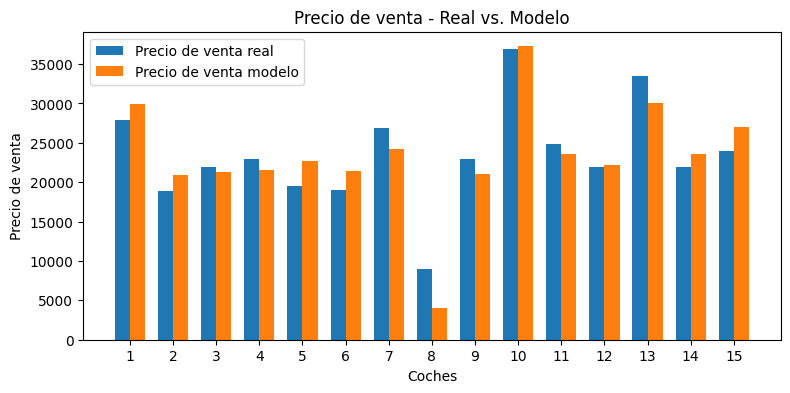

In [210]:
ind = np.arange(15)
width = 0.35

plt.figure(figsize=(9,4))
plt.bar(ind, y_test[:15], width, label='Precio de venta real')
plt.bar(ind+width, y_pred[:15], width, label='Precio de venta modelo')

plt.xticks(ind+width/2, np.arange(1, 16))
plt.legend(loc='best')

plt.xlabel('Coches')
plt.ylabel('Precio de venta')
plt.title('Precio de venta - Real vs. Modelo')

plt.show()